# *in progress*

# Automatic Inference
Author: Connacher Murphy

I implement the procedure described in [Farrell, Liang, and Misra (2021)](https://arxiv.org/abs/2010.14694). I make use of R code provided in the Causal Machine Learning course offered in the Fall of 2023 by Max Farrell and Sanjog Misra.

The parameter of interest is $\mu_0 = \mathbb{E}[\mathbf{H}(\mathbf{X},\mathbf{\theta}(\mathbf{X}); \mathbf{Z})]$. The outcome variable $Y$ is linked to the parameter functions $\mathbf{\theta}(\cdot)$ by the equality $\mathbb{E}[Y | \mathbf{X} = \mathbf{x}, \mathbf{Z} = \mathbf{z}] = G(\mathbf{\theta}(\mathbf{X}), \mathbf{Z})$.

When projecting the Hessian of the loss function onto $\mathbf{X}$ for the estimation of $\mathbf{\Lambda}(\mathbf{X})$, it is sometimes possible to avoid estimation. For example, with a linear $G(\mathbf{\theta}(\mathbf{X}), \mathbf{Z})$ and squared loss, we can compute the Hessian directly. This code does _not_ account for such possibilities and will rely on automatic differentiation for the Hessian and a DNN for the projection of this Hessian onto X.

_Caution_: Some parts of this code are specialized to the $\operatorname{dim}(\mathbf{\theta}) = 2$ case. I plan to make the code more flexible along this dimension.

### 0.1. Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.linalg as linalg
import torch.autograd as autograd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm # ascii progress bar

# torch.autograd.set_detect_anomaly(True)

### 0.2. DNN training tools

In [2]:
# Create a class for a DNN with ReLU activation and Kaiming initialization
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_sizes, output_dim, dropout_rate):
        super(DeepNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        prev_size = input_dim
        for hidden_size in hidden_sizes:
            linear = nn.Linear(prev_size, hidden_size)
            nn.init.kaiming_normal_(linear.weight, mode = 'fan_in')
            self.layers.append(linear)
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        self.layers.append(nn.Linear(prev_size, output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [3]:
def train_DNN(
        X, Y, Z,
        theta_dim, G,
        hidden_sizes, dropout_rate, loss_function, learning_rate, weight_decay,
        num_epochs
):
    input_dim = X.size(1)
    num_hidden_layers = np.shape(hidden_sizes)[0]
    print(f'Training NN with {num_hidden_layers} layers')

    model = DeepNeuralNetwork(
        input_dim, hidden_sizes, theta_dim, dropout_rate
    )

    # Select the optimizer; we use stochastic gradient descent
    optimizer = optim.SGD(
        model.parameters(), lr = learning_rate, weight_decay = weight_decay
    )

    # loss_history = [] # keep track of the loss at each epoch

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        # Forward pass
        structural_parameters = model(X)
        outputs = G(structural_parameters, Z)
        
        loss = loss_function(outputs, Y)
        if np.isnan(float(loss)):
            print('NaN loss detected :(')
            print(loss)
            break
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update parameters
        optimizer.step()

        # loss_history.append(float(loss))

        # Print the loss every 10 epochs
        # if (epoch + 1) % 10 == 0:
        #         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return(model)

### 0.3. Data generating process (DGP)

In [4]:
torch.manual_seed(12345) # Set the seed for reproducibility

N = 15000 # observation count
K = 2 # feature count

X = torch.randn(N, K) # draw independent features from standard normal

alpha = X[:, 0].view(N, 1)
beta = 3 + X[:, 1].view(N, 1)

theta_dim = 2 # dim(theta)

Z = 1 * (torch.randn(N, 1) > 0).view(N, 1)

Y = alpha + beta * Z + torch.randn(N, 1) # generate Y

In [5]:
# Create splits
perm = torch.randperm(N) # create a permutation of the indices

num_splits = 3 # number of splits

split_size = N // num_splits # compute the size of each split

splits = [] # store splits in a list of dictionaries
for s in range(num_splits):
    indices = perm[s * split_size:(s + 1) * split_size]
    
    # Use indices to create a split
    split = {'X': X[indices], 'Y': Y[indices], 'Z': Z[indices],
             'alpha': alpha[indices], 'beta': beta[indices]}

    # Add the split to the list of splits
    splits.append(split)

### 1.1. Prepare for estimation

In [6]:
def G(theta, Z): # define G(theta) function
    N = Z.size(0)
    
    H_eval = torch.add(
        theta[:,0],
        torch.mul(theta[:,1], Z.view(N))
    ).view(N, 1)

    return(H_eval)

### 1.1. Estimate $\mathbf{\theta}$

In [7]:
# Hyperparameters
learning_rate = 5e-3
# weight_decay = 1e-3 # L2 regularization
weight_decay = 0.0 # no L2 regularization
num_epochs = 2000

In [8]:
# Store the results in a list
model_theta = [] # trained models
# theta = [] # parameter predictions
# outputs = [] # predictions for Y

print('Estimating theta')
for s in range(num_splits):
    print(f'Split {s + 1}')

    model = train_DNN(splits[s]['X'], splits[s]['Y'], splits[s]['Z'],
                      theta_dim, G, [30, 30], 0.0,
                      nn.MSELoss(reduction = 'mean'),
                      learning_rate, weight_decay, num_epochs)
    
    model_theta.append(model)
    # theta.append(model(splits[s]['X']))

    # theta = model_theta(X) # parameter predictions
    # outputs = G(theta, Z)
    # theta.retain_grad()

Estimating theta
Split 1
Training NN with 2 layers


100%|██████████| 2000/2000 [00:02<00:00, 829.58it/s]


Split 2
Training NN with 2 layers


100%|██████████| 2000/2000 [00:02<00:00, 866.83it/s]


Split 3
Training NN with 2 layers


100%|██████████| 2000/2000 [00:02<00:00, 875.55it/s]


In [9]:
alpha_np = np.array([]) # truth
beta_np = np.array([])
Y_np = np.array([])

alpha_est_np = np.array([]) # estimates
beta_est_np = np.array([])
Y_est_np = np.array([])

for s in range(num_splits):
    alpha_np = np.append(alpha_np, splits[s]['alpha'].detach().numpy())
    beta_np = np.append(beta_np, splits[s]['beta'].detach().numpy())
    Y_np = np.append(Y_np, splits[s]['Y'].detach().numpy())
    
    alpha_est_np = np.append(
        alpha_est_np, model_theta[s](splits[s]['X'])[:,0].detach().numpy()
    )
    beta_est_np = np.append(
        beta_est_np, model_theta[s](splits[s]['X'])[:,1].detach().numpy()
    )
    outputs = G(model_theta[s](splits[s]['X']), splits[s]['Z'])
    Y_est_np = np.append(Y_est_np, outputs.detach().numpy())

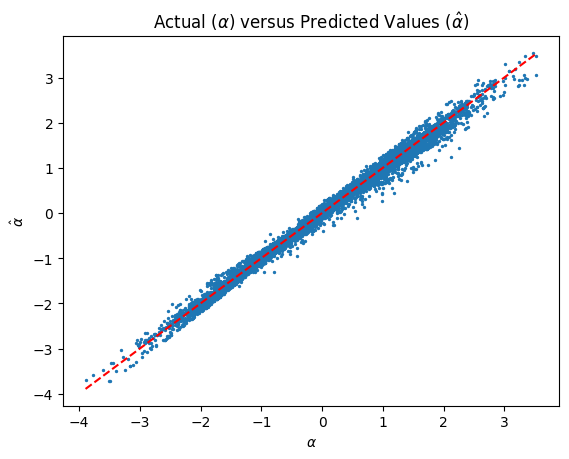

In [10]:
plt.scatter(alpha_np, alpha_est_np, s = 2)
plt.plot([min(alpha_np), max(alpha_np)], [min(alpha_np), max(alpha_np)],
         color = 'r', linestyle = '--')
plt.title('Actual ($\\alpha$) versus Predicted Values ($\hat{\\alpha}$)')
plt.xlabel('$\\alpha$')
plt.ylabel('$\hat{\\alpha}$')
plt.savefig('out/alpha_est.png')
plt.show()

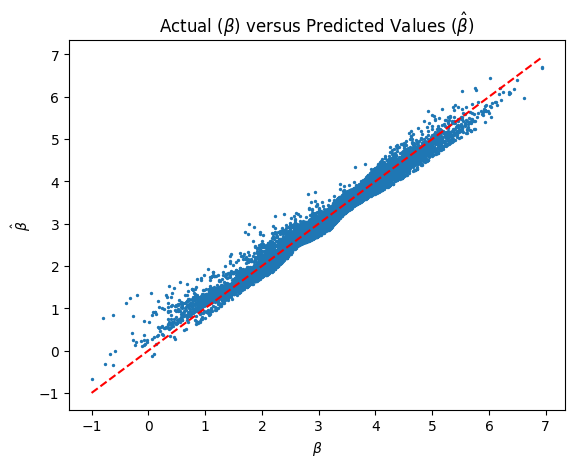

In [11]:
plt.scatter(beta_np, beta_est_np, s = 2)
plt.plot([min(beta_np), max(beta_np)], [min(beta_np), max(beta_np)],
         color = 'r', linestyle = '--')
plt.title('Actual ($\\beta$) versus Predicted Values ($\hat{\\beta}$)')
plt.xlabel('$\\beta$')
plt.ylabel('$\hat{\\beta}$')
plt.savefig('out/beta_est.png')
plt.show()

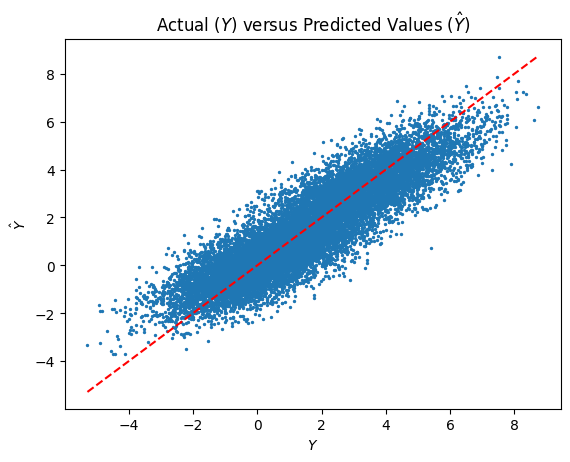

In [12]:
plt.scatter(Y_np, Y_est_np, s = 2)
plt.plot([min(Y_np), max(Y_np)], [min(Y_np), max(Y_np)],
         color = 'r', linestyle = '--')
plt.title('Actual ($Y$) versus Predicted Values ($\hat{Y}$)')
plt.xlabel('$Y$')
plt.ylabel('$\hat{Y}$')
plt.savefig('out/Y_est.png')
plt.show()

### 1.2. Estimate $\mathbf{\Lambda}(\mathbf{X})$

In [13]:
def identity(theta, Z): # simple identity function for G(Theta)
    return(theta)

# Estimate Lambda for a given split and DNN
def estimate_Lambda(split, dnn, theta_dim, G, loss_function):
    print(f'Split {split + 1} with DNN {dnn + 1}')

    # Number of observations in the split
    N = splits[split]['X'].size(0)

    # Evaluate the structural parameter functions
    theta = model_theta[dnn](splits[split]['X'])

    # Predict outcomes
    outputs = G(theta, splits[split]['Z'])

    # Calculate loss
    loss = loss_function(outputs, splits[split]['Y'])

    # Gradient of loss w.r.t. theta
    theta_grad = autograd.grad(
        loss, theta, create_graph = True, retain_graph= True
    )[0]

    # Initialize Hessian
    Lambda = torch.zeros([N, theta_dim, theta_dim])
    
    for k in range(theta_dim):
        hess_row = autograd.grad( # row k of Hessian
            theta_grad[:,k].sum(), theta, retain_graph = True
        )

        for j in range(k, theta_dim): # only need to compute upper triangle
            print(f'Element ({k}, {j})')
            
            # Extract Hessian element (k,j)
            hess_element = hess_row[0][:,j]

            # Project Hessian element (k,j) onto X
            hess_element_projection = train_DNN( 
                splits[split]['X'], hess_element.view(N, 1), splits[split]['Z'],
                1, identity, [30, 30], 0.0, nn.MSELoss(reduction = 'mean'),
                learning_rate, weight_decay, num_epochs
            )

            # Store projection
            Lambda[:,k,j] = hess_element_projection(splits[split]['X']).view(N)

            if k != j: # reflect upper triangle to lower triangle
                Lambda[:,j,k] = Lambda[:,k,j]
                print(f'Reflecting to element ({j}, {k})')
    print('\n')

    return(Lambda)

In [14]:
loss_function = nn.MSELoss(reduction = 'sum')

print('Projecting Hessian onto X\n')

Lambdas = []

Lambdas.append(estimate_Lambda(0, 2, theta_dim, G, loss_function))
Lambdas.append(estimate_Lambda(1, 0, theta_dim, G, loss_function))
Lambdas.append(estimate_Lambda(2, 1, theta_dim, G, loss_function))

Projecting Hessian onto X

Split 1 with DNN 3
Element (0, 0)
Training NN with 2 layers


100%|██████████| 2000/2000 [00:02<00:00, 943.05it/s]


Element (0, 1)
Training NN with 2 layers


100%|██████████| 2000/2000 [00:02<00:00, 847.20it/s]


Reflecting to element (1, 0)
Element (1, 1)
Training NN with 2 layers


100%|██████████| 2000/2000 [00:02<00:00, 952.74it/s]




Split 2 with DNN 1
Element (0, 0)
Training NN with 2 layers


100%|██████████| 2000/2000 [00:02<00:00, 908.57it/s]


Element (0, 1)
Training NN with 2 layers


100%|██████████| 2000/2000 [00:02<00:00, 943.90it/s]


Reflecting to element (1, 0)
Element (1, 1)
Training NN with 2 layers


100%|██████████| 2000/2000 [00:02<00:00, 941.43it/s]




Split 3 with DNN 2
Element (0, 0)
Training NN with 2 layers


100%|██████████| 2000/2000 [00:02<00:00, 968.55it/s]


Element (0, 1)
Training NN with 2 layers


100%|██████████| 2000/2000 [00:02<00:00, 973.21it/s]


Reflecting to element (1, 0)
Element (1, 1)
Training NN with 2 layers


100%|██████████| 2000/2000 [00:02<00:00, 966.45it/s]

### 1.3. Influence function

In [15]:
# Estimate influence function for a given split, DNN, and Lambda
def estimate_influence_function(split, dnn, Lambda, theta_dim, G, H, loss_function):
    print(f'Split {split + 1} with DNN {dnn + 1}')
    
    # Number of observations in the split
    N = splits[split]['X'].size(0)

    # Evaluate the structural parameter functions
    theta = model_theta[dnn](splits[split]['X'])
    
    # Predict outcomes
    outputs = G(theta, splits[split]['Z'])

    # Calculate loss
    loss = loss_function(outputs, splits[split]['Y'])

    # Gradient of loss w.r.t. theta
    theta_grad = autograd.grad(
        loss, theta, create_graph = True, retain_graph= True
    )[0]

    # Evaluate H(.)
    H_eval = H(theta, splits[split]['Z'])

    # Gradient of H for adjustment term
    H_theta = autograd.grad(H_eval.sum(), theta)[0]

    influence_function = H_eval - torch.matmul(
        torch.matmul(
            H_theta.view(N, 1, theta_dim), linalg.pinv(Lambdas[Lambda])
        ).view(N, 1, theta_dim),
        theta_grad.view(N, theta_dim, 1)
    ).view(N, 1)

    return(influence_function)

In [16]:
# Define H(theta) function
def H(theta, Z): # we let H(theta(X)) = beta(X)
    N = Z.size(0)
    return(theta[:,1].view(N, 1))

loss_function = nn.MSELoss(reduction = 'sum')

print('Estimating influence function')

influence_function = [] # store influence function estimates

influence_function.append(
    estimate_influence_function(0, 1, 2, theta_dim, G, H, loss_function)
)
influence_function.append(
    estimate_influence_function(1, 2, 0, theta_dim, G, H, loss_function)
)
influence_function.append(
    estimate_influence_function(2, 0, 1, theta_dim, G, H, loss_function)
)

Estimating influence function
Split 1 with DNN 2
Split 2 with DNN 3
Split 3 with DNN 1


In [17]:
# Concatenate influence function values across splits and store as np array
influence_function_np = np.concatenate([
    influence_function[0].detach().numpy(),
    influence_function[1].detach().numpy(),
    influence_function[2].detach().numpy()
])

# Calculate estimate and standard error from concatenated influence function
est = influence_function_np.mean()
se = math.sqrt(influence_function_np.var() / N)

In [18]:
# Report results
print('Mean:', round(est, 4))
print('S.E.:', round(se, 4))
print('95% CI: [', round(est - 1.96 * se, 4), ', ',
      round(est + 1.96 * se, 4), ']', sep = '')

Mean: 2.9937
S.E.: 0.0186
95% CI: [2.9573, 3.0301]
